<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/Lec_8/Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from urllib.request import urlopen
from imageio import imread
import requests
import io
from time import time

import cv2 
import os, shutil


import warnings
warnings.filterwarnings('ignore')

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout
# %load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0] , True)
    print('Running on GPU ...')
else:
    print('Running on CPU ...')



Running on GPU ...


In [3]:
n_ts = 6  ## Length of each time sequence or the forcast window
n_f = 1
n_prediction = 60

# Univariate RNN

## Data
For this part, we use the sunspot data. This data contains the mean value of the number of sunspots for each month from 1749. 

You can find more information about this dataset from [SIDC](http://www.sidc.be/silso/ssngraphics). 

In [44]:
# data = pd.read_csv('monthly-sunspots.csv', index_col = 0)
import requests, io
url = 'https://raw.githubusercontent.com/sraeisi/Machine_Learning_Physics_Winter20/SampleData/monthly-sunspots.csv'
c = requests.get(url, stream=True).content
data = pd.read_csv(io.BytesIO(c), index_col = 0)

data.head()

,Sunspots
Month,
1749-01,58.0
1749-02,62.6
1749-03,70.0
1749-04,55.7
1749-05,85.0


In [6]:
data.iloc[-1]

Sunspots    33.4
Name: 1983-12, dtype: float64

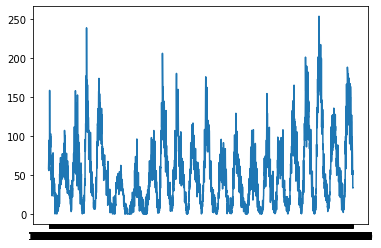

In [7]:
'''
Let's first plot the data to see if it does have a trend. 
'''
plt.plot(data.Sunspots)
plt.title = 'Sunspots in time'
plt.xlabel = 'Time (in month)'
plt.ylabel = 'Sunspots'
plt.show()

In [0]:
'''
As usuall, it is important to standardize/normalize the data. 
'''

print(f'The maximum value is {data.Sunspots.max()}')
data.Sunspots = data.Sunspots/data.Sunspots.max()

The maximum value is 253.8


### Generating the time-sequences

In [4]:
'''
The data in its current format, is not suitable for training a NN. 
We need to make the time-sequeces. 
For this, we add new columns to the dataframe and each new col 
is the same data but shifted. We create n_ts cols to collect
all the past n_ts data for each row. 
The output is a square matrix where each row is a time sequence. 
We also use the actual value as the target. 
'''
def prepare_time_seqs(data):
    output_df = pd.DataFrame()
    for i in range(n_ts):
        output_df[i] = data.Sunspots.shift(n_ts-i)
    output_df['target'] = data.Sunspots        
    return output_df


In [5]:
df = prepare_time_seqs(data)
df.head(10)

,0,1,2,3,4,5,target
Month,,,,,,,
1749-01,NaN,NaN,NaN,NaN,NaN,NaN,58.0
1749-02,NaN,NaN,NaN,NaN,NaN,58.0,62.6
1749-03,NaN,NaN,NaN,NaN,58.0,62.6,70.0
1749-04,NaN,NaN,NaN,58.0,62.6,70.0,55.7
1749-05,NaN,NaN,58.0,62.6,70.0,55.7,85.0
1749-06,NaN,58.0,62.6,70.0,55.7,85.0,83.5
1749-07,58.0,62.6,70.0,55.7,85.0,83.5,94.8
1749-08,62.6,70.0,55.7,85.0,83.5,94.8,66.3
1749-09,70.0,55.7,85.0,83.5,94.8,66.3,75.9


In [6]:
'''
The shift operator creates some NAN values since for the boundary, 
there's no value to be shifted forward. 
We can simply drop them. 
Note that if you want to increase n_ts, dropping the NaN values 
could result in significant data loss. 
'''
df.dropna(axis=0, inplace=True)
df.head()

,0,1,2,3,4,5,target
Month,,,,,,,
1749-07,58.0,62.6,70.0,55.7,85.0,83.5,94.8
1749-08,62.6,70.0,55.7,85.0,83.5,94.8,66.3
1749-09,70.0,55.7,85.0,83.5,94.8,66.3,75.9
1749-10,55.7,85.0,83.5,94.8,66.3,75.9,75.5
1749-11,85.0,83.5,94.8,66.3,75.9,75.5,158.6


In [7]:
'''
Next we form the X and Y. 
It is important to shape X to 
(n_s, n_ts, n_f)

For this example. n_f is one. 
'''

Y = df.target.values
X = df.drop('target', axis=1).values
print(X.shape)
X = X.reshape(-1, n_ts, n_f)
X.shape

(2814, 6)


(2814, 6, 1)

In [8]:
'''
Before generating the train and validation sets, let's 
hold a portion of the data for prediction. 
We seperate the data for the last n_prediction 
months and later test to see how well our model 
can predict the target for these months. 
'''
X_future = X[-n_prediction:]
Y_future = Y[-n_prediction:]

X = X[:-n_prediction]
Y = Y[:-n_prediction]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
print(X_train.shape)

(2065, 6, 1)


## Simple non-RNN model

In [11]:
from tensorflow.keras.layers import LSTM, RNN, GRU, Dense, Dropout

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Flatten(input_shape =(n_ts, n_f) ))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', 
              loss=tf.keras.losses.mean_squared_error)

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train,Y_train, 
                    epochs=100, batch_size = 64, 
                    verbose=0 , 
#                     callbacks=my_callbacks, 
                    validation_data = (X_test, Y_test))

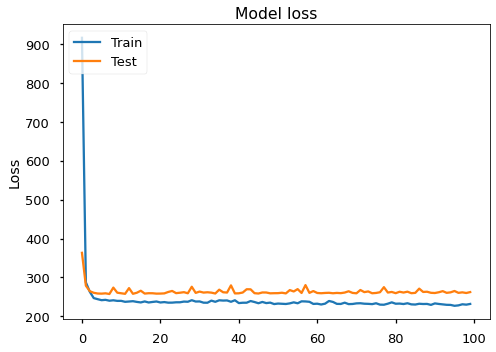

In [22]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

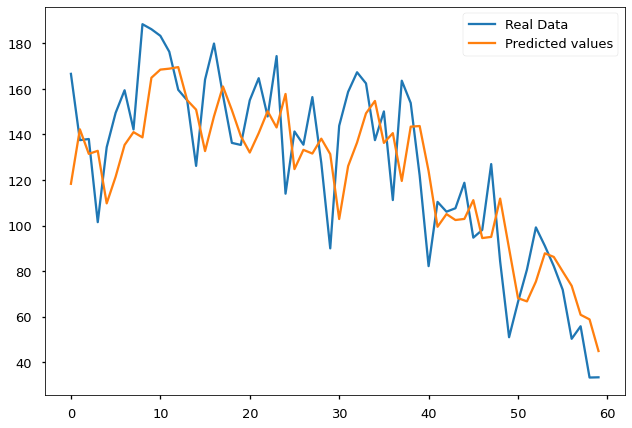

In [26]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
Y_fut_predicted = model.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.legend(loc=0)
plt.show()

## Simple RNN model

In [34]:

# clear(model)
model = models.Sequential()
model.add(SimpleRNN(64, input_shape =(n_ts, n_f) , 
               activation='tanh', 
               return_sequences=True) 
         )

model.add(SimpleRNN(32,  activation='tanh')  )

model.add(Dense(32,  activation='relu')  )

model.add(Dense(1,  activation='linear')  )


model.compile(loss = keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr = .001) )


In [35]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 6, 64)             4224      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 8,417
Trainable params: 8,417
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train, Y_train, 
                    epochs=10, batch_size=16, 
                    verbose=1, validation_data=(X_test, Y_test))

Train on 2065 samples, validate on 689 samples
Epoch 1/10
2065/2065 [==============================] - 2s 1ms/sample - loss: 3338.7971 - val_loss: 2398.2338
Epoch 2/10
2065/2065 [==============================] - 1s 687us/sample - loss: 1435.7458 - val_loss: 945.4712
Epoch 3/10
2065/2065 [==============================] - 1s 696us/sample - loss: 630.0926 - val_loss: 524.7529
Epoch 4/10
2065/2065 [==============================] - 1s 696us/sample - loss: 412.0401 - val_loss: 376.7991
Epoch 5/10
2065/2065 [==============================] - 1s 679us/sample - loss: 342.2282 - val_loss: 325.1162
Epoch 6/10
2065/2065 [==============================] - 1s 692us/sample - loss: 306.5767 - val_loss: 334.4182
Epoch 7/10
2065/2065 [==============================] - 1s 701us/sample - loss: 286.3713 - val_loss: 287.3516
Epoch 8/10
2065/2065 [==============================] - 1s 701us/sample - loss: 278.4205 - val_loss: 295.5916
Epoch 9/10
2065/2065 [==============================] - 2s 772us/sample 

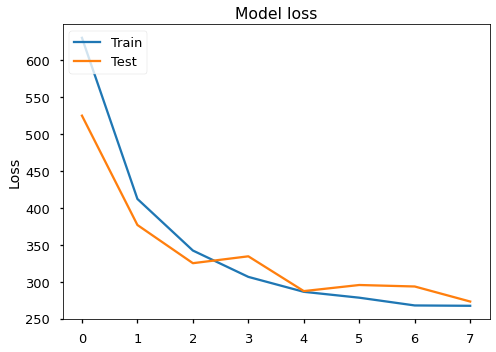

In [41]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

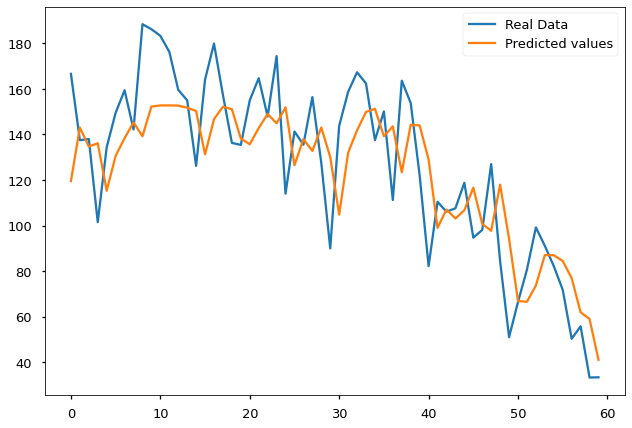

In [42]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, title = 'Time', ylabel= 'Loss')

Y_fut_predicted = model.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.xlabel = 'time'
plt.legend(loc=0)
plt.show()

## RNN with long short term memory (LSTM)

Next, we train a LSTM model. 

In [12]:

# clear(model)
model = models.Sequential()
model.add(LSTM(64, input_shape =(n_ts, n_f) , 
               activation='relu', 
               return_sequences=True) 
         )

model.add(LSTM(32,  activation='relu')  )

model.add(Dense(32,  activation='relu')  )

model.add(Dense(1,  activation='linear')  )


model.compile(loss = keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr = .001) )


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, Y_train, 
                    epochs=10, batch_size=16, 
                    verbose=1, validation_data=(X_test, Y_test))

Train on 2065 samples, validate on 689 samples
Epoch 1/10
2065/2065 [==============================] - 9s 4ms/sample - loss: 911.5672 - val_loss: 288.5775
Epoch 2/10
2065/2065 [==============================] - 4s 2ms/sample - loss: 301.8275 - val_loss: 312.3387
Epoch 3/10
2065/2065 [==============================] - 5s 2ms/sample - loss: 279.7797 - val_loss: 270.3172
Epoch 4/10
2065/2065 [==============================] - 4s 2ms/sample - loss: 262.1102 - val_loss: 297.5452
Epoch 5/10
2065/2065 [==============================] - 4s 2ms/sample - loss: 259.7806 - val_loss: 285.6661
Epoch 6/10
2065/2065 [==============================] - 4s 2ms/sample - loss: 257.9021 - val_loss: 293.0270
Epoch 7/10
2065/2065 [==============================] - 4s 2ms/sample - loss: 251.1740 - val_loss: 264.7079
Epoch 8/10
2065/2065 [==============================] - 4s 2ms/sample - loss: 256.5096 - val_loss: 264.5221
Epoch 9/10
2065/2065 [==============================] - 4s 2ms/sample - loss: 274.9605 - 

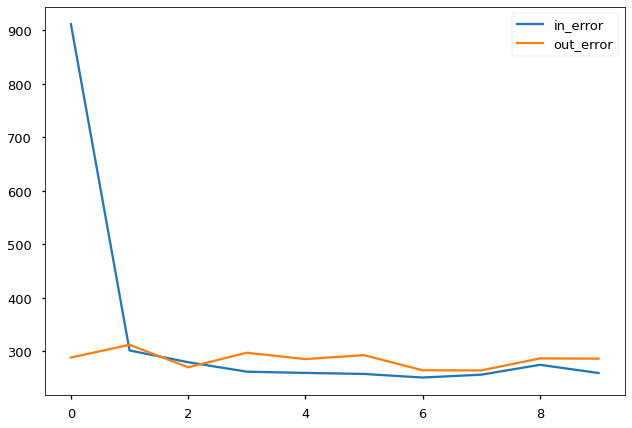

In [15]:
plt.plot(history.history['loss'], label='in_error')
plt.plot(history.history['val_loss'], label='out_error')
plt.title = 'Loss of the model'
plt.xlabel = 'Time (Epochs)'
plt.ylabel = 'Loss'
plt.legend(loc=0)
plt.show()

No handles with labels found to put in legend.


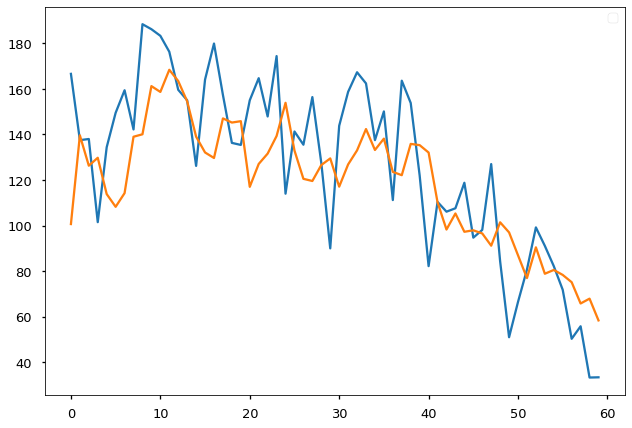

In [16]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
Y_fut_predicted = model.predict(X_future)
plt.plot(Y_future)
plt.plot(Y_fut_predicted)
plt.legend(loc=0)
plt.show()

# Multivariate RNN

In [3]:
'''
Here's the data for air pollution in Beijing, taken from 
http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data#

Use LSTM RNN models to predict the air pollution. 

'''
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
import requests, io

c = requests.get(url, stream=True).content
data = pd.read_csv(io.BytesIO(c), index_col = 0)
data.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
'''
We probably don't need year, month, day and hour if hour is always increasing by one. 
It should be enough to keep only the index. 
'''
data.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)
data.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            43815, 43816, 43817, 43818, 43819, 43820, 43821, 43822, 43823,
            43824],
           dtype='int64', name='No', length=43824)

## Dealing with nan values

In [5]:
data.isna().any()

pm2.5     True
DEWP     False
TEMP     False
PRES     False
cbwd     False
Iws      False
Is       False
Ir       False
dtype: bool

In [6]:
data['pm2.5'].isna().sum()

2067

In [7]:
print(len(data))

43824


In [0]:
'''
There are two many of them and we can't just remove those rows. 
So we replace the NaN values with the mean of the col. 
'''

data.fillna(data.mean(), inplace=True)

In [10]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,
1,98.613215,-21,-11.0,1021.0,NW,1.79,0,0
2,98.613215,-21,-12.0,1020.0,NW,4.92,0,0
3,98.613215,-21,-11.0,1019.0,NW,6.71,0,0
4,98.613215,-21,-14.0,1019.0,NW,9.84,0,0
5,98.613215,-20,-12.0,1018.0,NW,12.97,0,0


In [9]:
'''
Next we need to turn categorical values to numerical ones. 
'''
data.cbwd = data.cbwd.astype("category").cat.codes
data.head(20)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,
1,98.613215,-21,-11.0,1021.0,1,1.79,0,0
2,98.613215,-21,-12.0,1020.0,1,4.92,0,0
3,98.613215,-21,-11.0,1019.0,1,6.71,0,0
4,98.613215,-21,-14.0,1019.0,1,9.84,0,0
5,98.613215,-20,-12.0,1018.0,1,12.97,0,0
6,98.613215,-19,-10.0,1017.0,1,16.10,0,0
7,98.613215,-19,-9.0,1017.0,1,19.23,0,0
8,98.613215,-19,-9.0,1017.0,1,21.02,0,0
9,98.613215,-19,-9.0,1017.0,1,24.15,0,0


In [0]:
'''
We also need to normalize the data. 
'''
# normalized_data=(data-data.mean())/data.std()
normalized_data=(data-data.min())/(data.max()-data.min())


In [11]:
n_f = data.shape[1] 
n_f

8

In [12]:
hist = range(1,n_ts+1)

df = normalized_data.assign(**{
    '{} (h-{})'.format(col, t): normalized_data[col].shift(t)
    for t in hist
    for col in normalized_data
})

df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5 (h-1),DEWP (h-1),TEMP (h-1),PRES (h-1),cbwd (h-1),Iws (h-1),Is (h-1),Ir (h-1),pm2.5 (h-2),DEWP (h-2),TEMP (h-2),PRES (h-2),cbwd (h-2),Iws (h-2),Is (h-2),Ir (h-2),pm2.5 (h-3),DEWP (h-3),TEMP (h-3),PRES (h-3),cbwd (h-3),Iws (h-3),Is (h-3),Ir (h-3),pm2.5 (h-4),DEWP (h-4),TEMP (h-4),PRES (h-4),cbwd (h-4),Iws (h-4),Is (h-4),Ir (h-4),pm2.5 (h-5),DEWP (h-5),TEMP (h-5),PRES (h-5),cbwd (h-5),Iws (h-5),Is (h-5),Ir (h-5),pm2.5 (h-6),DEWP (h-6),TEMP (h-6),PRES (h-6),cbwd (h-6),Iws (h-6),Is (h-6),Ir (h-6)
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.099208,0.279412,0.131148,0.509091,0.333333,0.010698,0.0,0.0,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.099208,0.279412,0.081967,0.509091,0.333333,0.016047,0.0,0.0,0.099208,0.279412,0.131148,0.509091,0.333333,0.010698,0.0,0.0,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.099208,0.294118,0.114754,0.490909,0.333333,0.021396,0.0,0.0,0.099208,0.279412,0.081967,0.509091,0.333333,0.016047,0.0,0.0,0.099208,0.279412,0.131148,0.509091,0.333333,0.010698,0.0,0.0,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.00229,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
### Next we get rid of the first n_ts rows that have nan values. 
df.dropna(axis=0, inplace=True)

In [14]:
### The target is the pollution of the day
Y = df['pm2.5'].values

### Then we get rid of all the measurements of that day. 
X = df.drop(data.columns, axis=1).values

print(X.shape)
X = X.reshape(-1, n_ts, n_f)
X.shape

(43818, 48)


(43818, 6, 8)

In [0]:
'''
Before generating the train and validation sets, let's 
hold a portion of the data for prediction. 
We seperate the data for the last n_prediction 
months and later test to see how well our model 
can predict the target for these months. 
'''
X_future = X[-n_prediction:]
Y_future = Y[-n_prediction:]

X = X[:-n_prediction]
Y = Y[:-n_prediction]

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
print(X_train.shape)

(32818, 6, 8)


In [0]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

In [0]:
model2.reset_metrics()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 32818 samples, validate on 10940 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
32818/32818 [==============================] - 19s 583us/sample - loss: 0.0019 - val_loss: 9.8311e-04
Epoch 2/50
32818/32818 [==============================] - 13s 400us/sample - loss: 0.0013 - val_loss: 8.8052e-04
Epoch 3/50
32818/32818 [==============================] - 13s 405us/sample - loss: 0.0012 - val_loss: 7.2698e-04
Epoch 4/50
32818/32818 [==============================] - 14s 421us/sample - loss: 0.0011 - val_loss: 7.2778e-04
Epoch 5/50
32818/32818 [==============================] - 14s 413us/sample - loss: 0.0011 - val_loss: 7.9812e-04
Epoch 6/50
32818/32818 [==============================] - 13s 399us/sample - loss: 0.0011 - val_loss: 6.5828e-04
Epoch 7/50
32818/32818 [=============

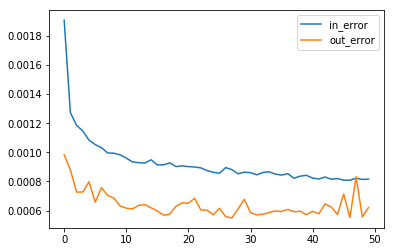

In [19]:
model2 = keras.models.Sequential()
model2.add(LSTM(64, input_shape =(n_ts, n_f) , 
                     return_sequences=True)  )
model2.add(Dropout(.1))

model2.add(LSTM(32)  )
model2.add(Dropout(.2))

model2.add(Dense(32,  activation='relu')  )
model2.add(Dropout(.2))

model2.add(Dense(1,  activation='linear')  )


model2.compile(loss = keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr = .001) )
history2 = model2.fit(X_train, Y_train, epochs=50, 
                      batch_size=16, verbose=1, 
                      validation_data=(X_test, Y_test))


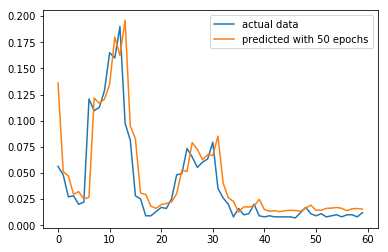

In [31]:
Y_fut_predicted2 = model2.predict(X_future)
plt.plot(Y_future, label = 'actual data')
plt.plot(Y_fut_predicted2, label = 'predicted with 50 epochs')
plt.legend(loc=0)
plt.show()